# <div align="center"> Assignment 2 </div>

###  <div align="center"> Sumeth Lokuliyana (s3904996) </div>
###  <div align="center"> Janak Datta Velagapudi (s3903576) </div>

## <div align="center"> Classify Images based on Cell Type  </div>

### * As for this section we will be predicting images of cancer cells based non Cell type.

### Import required packages 

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
import pandas as pd
import cv2
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.optimizers import RMSprop, Adadelta,SGD,Adamax
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import LearningRateScheduler, ModelCheckpoint ,EarlyStopping
import matplotlib.pyplot as plt
from keras.losses import categorical_crossentropy
from keras.metrics import Precision, Recall, AUC

### Reading the CSV file and the images into a DataFrame .

##### The images are first read using the cv2 read and then appends it to an array . Similarly we add the image path to the dataframe as well.
We use cv2 library to convert the image into a list and we append that into the df , this gives more information about each image to the model.

In [2]:
main_csv_file = "data_labels_mainData.csv"
extra_csv_file = "data_labels_extraData.csv"
df = pd.read_csv(main_csv_file)
extra_df = pd.read_csv(extra_csv_file)

image_dir = "patch_images"
image_arrays = []
image_path = []
for image_name in df["ImageName"]:
    image_pth = image_dir + "/" + image_name
    image_path.append(image_pth)
    img = cv2.imread(os.path.join(image_dir, image_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB format
    image_arrays.append(img)
image_arrays = np.array(image_arrays)


df["image_data"] = list(image_arrays)
df["image_path"] = image_path
df

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,image_data,image_path
0,22405,1,22405.png,fibroblast,0,0,"[[[242, 213, 237], [239, 209, 233], [235, 205,...",patch_images/22405.png
1,22406,1,22406.png,fibroblast,0,0,"[[[221, 175, 211], [224, 175, 211], [233, 184,...",patch_images/22406.png
2,22407,1,22407.png,fibroblast,0,0,"[[[247, 243, 247], [248, 242, 246], [247, 239,...",patch_images/22407.png
3,22408,1,22408.png,fibroblast,0,0,"[[[243, 242, 242], [243, 241, 241], [243, 241,...",patch_images/22408.png
4,22409,1,22409.png,fibroblast,0,0,"[[[189, 130, 189], [186, 126, 184], [187, 126,...",patch_images/22409.png
...,...,...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1,"[[[171, 138, 180], [217, 186, 228], [252, 224,...",patch_images/1625.png
9892,1626,60,1626.png,epithelial,2,1,"[[[212, 173, 228], [185, 145, 207], [164, 124,...",patch_images/1626.png
9893,1627,60,1627.png,epithelial,2,1,"[[[175, 141, 193], [196, 168, 209], [214, 188,...",patch_images/1627.png
9894,1628,60,1628.png,epithelial,2,1,"[[[227, 202, 232], [176, 146, 193], [183, 146,...",patch_images/1628.png


### Splitting the data into `Train` and `Test` sets


##### Initially we create a df of features that has the cellTypeName , celltype , isCancerous,  the image data and the image path 

In [3]:
df = df.drop("ImageName", axis = 1)
df = df.drop("InstanceID", axis = 1)
df = df.drop("patientID", axis = 1)


X_train, X_test = train_test_split(df, test_size = 0.2, random_state = 42)
X_test, X_val = train_test_split(X_test, test_size = 0.2, random_state = 42)
display(df)
display(X_train.shape)
display(X_test.shape)
display(X_val.shape)

,cellTypeName,cellType,isCancerous,image_data,image_path
0,fibroblast,0,0,"[[[242, 213, 237], [239, 209, 233], [235, 205,...",patch_images/22405.png
1,fibroblast,0,0,"[[[221, 175, 211], [224, 175, 211], [233, 184,...",patch_images/22406.png
2,fibroblast,0,0,"[[[247, 243, 247], [248, 242, 246], [247, 239,...",patch_images/22407.png
3,fibroblast,0,0,"[[[243, 242, 242], [243, 241, 241], [243, 241,...",patch_images/22408.png
4,fibroblast,0,0,"[[[189, 130, 189], [186, 126, 184], [187, 126,...",patch_images/22409.png
...,...,...,...,...,...
9891,epithelial,2,1,"[[[171, 138, 180], [217, 186, 228], [252, 224,...",patch_images/1625.png
9892,epithelial,2,1,"[[[212, 173, 228], [185, 145, 207], [164, 124,...",patch_images/1626.png
9893,epithelial,2,1,"[[[175, 141, 193], [196, 168, 209], [214, 188,...",patch_images/1627.png
9894,epithelial,2,1,"[[[227, 202, 232], [176, 146, 193], [183, 146,...",patch_images/1628.png


(7916, 5)

(1584, 5)

(396, 5)

### We will now check the distribution of each type of cell

[4079 2543 1888 1386] Index([2, 1, 0, 3], dtype='int64', name='cellType')


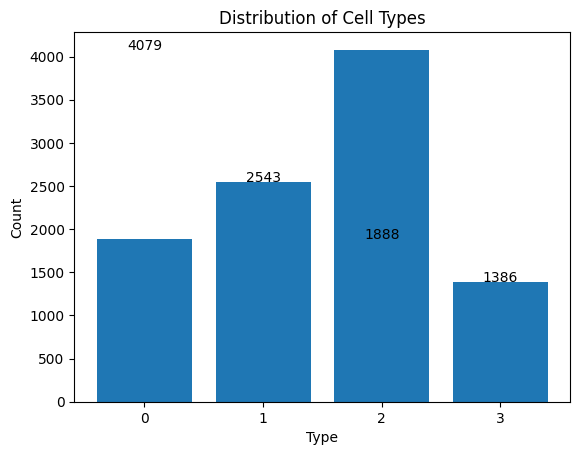

In [4]:
target_counts = df["cellType"].value_counts()
print(target_counts.values,target_counts.index )

plt.bar(target_counts.index, target_counts.values)
plt.xticks(target_counts.index)
plt.title("Distribution of Cell Types")
plt.xlabel("Type")
plt.ylabel("Count")

for i, value in enumerate(target_counts.values):
    plt.text(i, value, str(value), ha='center')

plt.show()


+ From the graph we can say that cell of type 2 is the most common , and the least common one would be cell type 3 which is 1386.

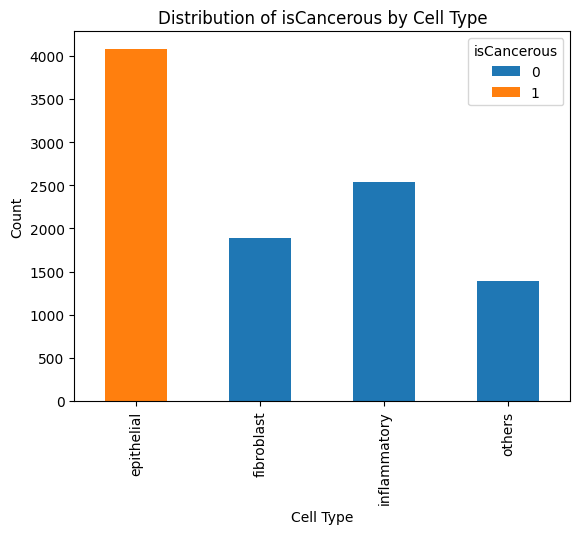

In [5]:
grouped = df.groupby(['isCancerous', 'cellTypeName'])['cellTypeName'].count().unstack('isCancerous')
grouped.plot(kind='bar', stacked=True)
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.title('Distribution of isCancerous by Cell Type')
plt.show()

+ Based on the graph Epithelial cells has the highest amount of cancerous Cells.

## Plotting  images of random cells along with the cell Type

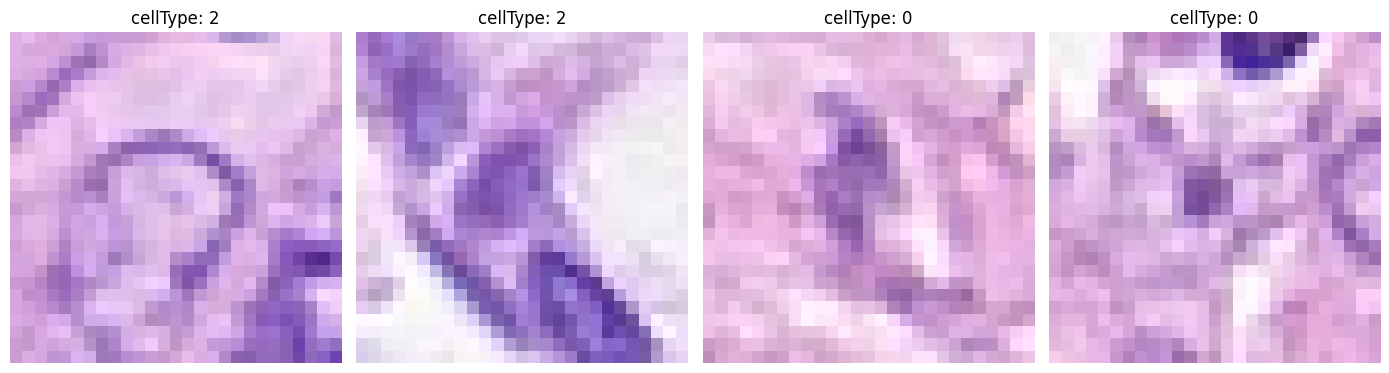

In [6]:
r_idx = np.random.choice(9896, 4)
rand_data = df.loc[r_idx, ["image_path", "cellType"]]

plt.figure(figsize=(14, 4))

for i, (image_path, cellType) in enumerate(zip(rand_data["image_path"], rand_data["cellType"])):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1, 4, i+1)
    plt.imshow(im)
    plt.title(f"cellType: {cellType}")
    plt.axis("off")  # Remove axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

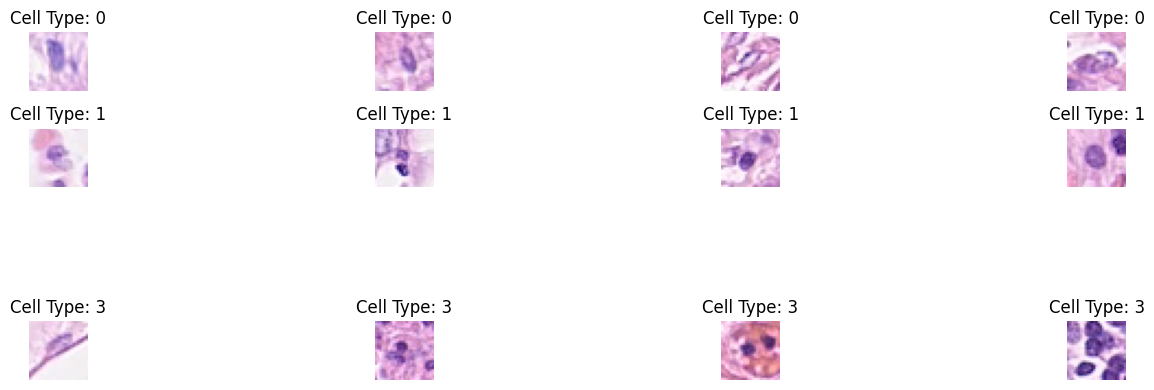

In [7]:
non_cancerous_data = df[df['isCancerous'] == 0]

plt.figure(figsize=(14, 4))

for cellType in range(4):
    # Filter the non-cancerous data for each cell type
    cell_data = non_cancerous_data[non_cancerous_data['cellType'] == cellType]
    if len(cell_data) > 0:
        # Randomly select four images for each cell type
        rand_data = cell_data.sample(4)

        for i, (image_path, cellType) in enumerate(zip(rand_data['image_path'], rand_data['cellType'])):
            im = np.asarray(Image.open(image_path))
            plt.subplot(4, 4, cellType * 4 + i + 1)
            plt.imshow(im)
            plt.title(f'Cell Type: {cellType}')
            plt.axis('off')

plt.tight_layout()
plt.show()


## The base model

This model flattens the input picture into a 1D vector, passes it through a fully connected layer with 256 units, goes through the sigmoid activation function, and then runs it through another fully connected layer with 4 units and softmax activation to get the probabilities for each class(0,1,2,3).

In [8]:
base_model = Sequential([
    Flatten(input_shape = (27, 27, 3)),
    Dense(256, activation = 'sigmoid'),
    Dense(4, activation = 'softmax')
])

In [9]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


## Setting up ImageDataGenerators 

+ The `image generators` will rescale(optional) the images pixel values by dividing them by 255
+ The `target_size` argument determines the size to which the photos will be downsized/upsized in this case we keep it the same
+ The `batch_size` parameter provides the number of images to include in each batch during training and validation
+ The `class_mode` parameter is used based on the type of classification used in this case it is Categorical.

+ Since Image Data generators accepts only string , we have to convert the numeric values into string .

In [10]:
X_test['cellType'] = X_test['cellType'].astype('str')
X_train['isCancerous'] = X_train['isCancerous'].astype('str') 
X_val['isCancerous'] = X_val['isCancerous'].astype('str')


X_train['cellType'] = X_train['cellType'].astype('str') 
X_val['cellType'] = X_val['cellType'].astype('str')


train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory='./',
    x_col='image_path',
    y_col='cellType',
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory='./',
    x_col='image_path',
    y_col='cellType',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode='categorical'
)

test_generator =  test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory='./',
    x_col='image_path',
    y_col='cellType',
    target_size=(27, 27),
    batch_size = batch_size,
    class_mode='categorical'
)


Found 7916 validated image filenames belonging to 4 classes.
Found 396 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.


### Fitting the data given by the `ImageDataGenerators` to the base_model

In [11]:

base_model.compile(optimizer='sgd',loss=categorical_crossentropy,metrics=['categorical_accuracy', Precision(), Recall(), AUC()])
base_history = base_model.fit(train_generator,validation_data=validation_generator,epochs=200,verbose=1)

Epoch 1/200
248/248 [==============================] - 4s 14ms/step - loss: 1.2546 - categorical_accuracy: 0.4428 - precision: 0.7841 - recall: 0.0784 - auc: 0.6942 - val_loss: 1.1974 - val_categorical_accuracy: 0.5606 - val_precision: 0.8537 - val_recall: 0.0884 - val_auc: 0.7496
Epoch 2/200
248/248 [==============================] - 3s 13ms/step - loss: 1.1523 - categorical_accuracy: 0.5263 - precision: 0.8308 - recall: 0.2172 - auc: 0.7613 - val_loss: 1.1136 - val_categorical_accuracy: 0.6061 - val_precision: 0.8939 - val_recall: 0.1490 - val_auc: 0.8383
Epoch 3/200
248/248 [==============================] - 3s 13ms/step - loss: 1.0777 - categorical_accuracy: 0.5624 - precision: 0.8311 - recall: 0.2903 - auc: 0.8034 - val_loss: 1.0706 - val_categorical_accuracy: 0.5758 - val_precision: 0.7407 - val_recall: 0.4040 - val_auc: 0.7986
Epoch 4/200
248/248 [==============================] - 3s 13ms/step - loss: 1.0133 - categorical_accuracy: 0.6014 - precision: 0.8303 - recall: 0.3406 - a

## Graphs of Accuracy and Loss on Train and Validation data(base models)

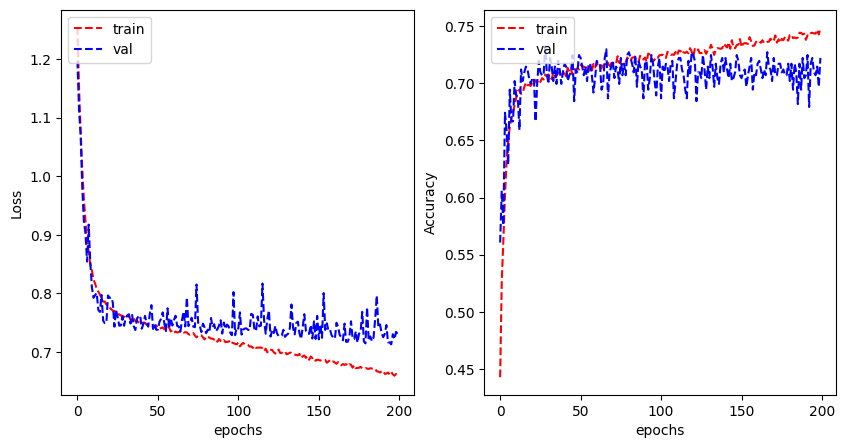

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(base_history.history['loss'], 'r--')
plt.plot(base_history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(base_history.history['categorical_accuracy'], 'r--')
plt.plot(base_history.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.show()

+ The base model is performed really well , initially it was undefitting and with time it overfitted the data , to reduce this we can use regularization and use a dropout layer

In [13]:
base_model.evaluate(test_generator)

50/50 [==============================] - 1s 12ms/step - loss: 0.7962 - categorical_accuracy: 0.6913 - precision: 0.7598 - recall: 0.6212 - auc: 0.8938


[0.7962404489517212,
 0.6912878751754761,
 0.7598455548286438,
 0.6212121248245239,
 0.8938330411911011]

### Regularization of the model 

This is done inorder to reduce the overfitting of the data as the validation accuracy is less than that of the training accuracy . In this case well carry out regularization , to test if it has effect on the model . To do this we add kernel_regularizer which uses the l2 function with the parameter 0.04 .

In [14]:
reg_lambda = 0.04
from keras.regularizers import l2

base_model_reg = Sequential([
    Flatten (input_shape = (27,27,3)),
    Dense (256, activation='sigmoid'),
    Dense(4, activation='softmax', kernel_regularizer=l2(reg_lambda))
])



base_model_reg.compile(optimizer='sgd',
                       loss=categorical_crossentropy,
                       metrics=['categorical_accuracy', Precision(), Recall(), AUC()])


history_reg = base_model_reg.fit(train_generator, validation_data = validation_generator, epochs= 100, verbose=1)

Epoch 1/100
248/248 [==============================] - 4s 15ms/step - loss: 1.5252 - categorical_accuracy: 0.4409 - precision_1: 0.7116 - recall_1: 0.0520 - auc_1: 0.6811 - val_loss: 1.4266 - val_categorical_accuracy: 0.4394 - val_precision_1: 0.8431 - val_recall_1: 0.1086 - val_auc_1: 0.7328
Epoch 2/100
248/248 [==============================] - 3s 14ms/step - loss: 1.3813 - categorical_accuracy: 0.4856 - precision_1: 0.8458 - recall_1: 0.1455 - auc_1: 0.7331 - val_loss: 1.3275 - val_categorical_accuracy: 0.5530 - val_precision_1: 0.8649 - val_recall_1: 0.1616 - val_auc_1: 0.7560
Epoch 3/100
248/248 [==============================] - 3s 14ms/step - loss: 1.2963 - categorical_accuracy: 0.5219 - precision_1: 0.8519 - recall_1: 0.2057 - auc_1: 0.7601 - val_loss: 1.2518 - val_categorical_accuracy: 0.5429 - val_precision_1: 0.8644 - val_recall_1: 0.2576 - val_auc_1: 0.7767
Epoch 4/100
248/248 [==============================] - 3s 14ms/step - loss: 1.2370 - categorical_accuracy: 0.5430 - pr

## Graphs of Accuracy and Loss on Train and Validation data(regularized model)

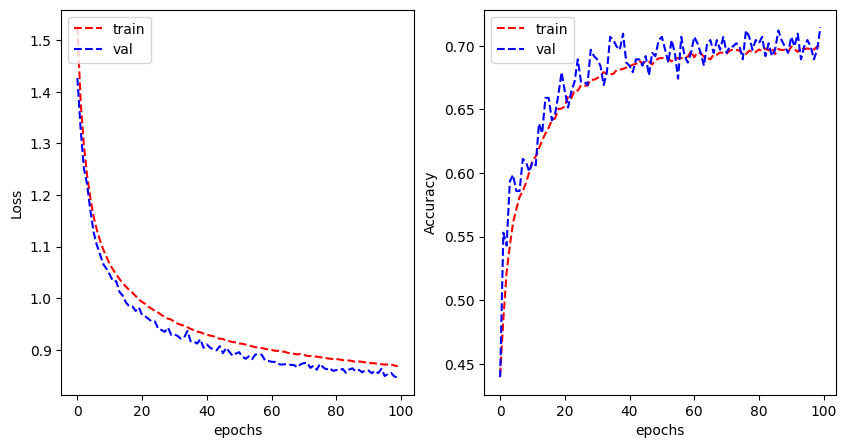

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.show()

+ The data is now not over fitting but is has low undefiiting probability , but regularization was a success as it reduced overfitting of the model.

In [16]:
base_model_reg.evaluate(test_generator)

50/50 [==============================] - 1s 12ms/step - loss: 0.9056 - categorical_accuracy: 0.6913 - precision_1: 0.7844 - recall_1: 0.5215 - auc_1: 0.8857


[0.9056440591812134,
 0.6912878751754761,
 0.7844254374504089,
 0.5214646458625793,
 0.8857197761535645]

## Adding a `Dropout` layer to reduce Overfitting



In [17]:
add_lyrs_class = Sequential([
    Flatten (input_shape=(27,27,3)), 
    Dense (256, activation='sigmoid'), 
    Dropout (0.3),
    Dense (4, activation='softmax')
])


add_lyrs_class.compile(optimizer='sgd',
                           loss = categorical_crossentropy,
                           metrics=['categorical_accuracy', Precision(), Recall(), AUC()])

history_reg_drp = add_lyrs_class.fit(train_generator, validation_data = validation_generator, epochs=200, verbose=1)

Epoch 1/200
248/248 [==============================] - 4s 14ms/step - loss: 1.3276 - categorical_accuracy: 0.4010 - precision_2: 0.5082 - recall_2: 0.1258 - auc_2: 0.6462 - val_loss: 1.2073 - val_categorical_accuracy: 0.5303 - val_precision_2: 0.8750 - val_recall_2: 0.0707 - val_auc_2: 0.7444
Epoch 2/200
248/248 [==============================] - 3s 13ms/step - loss: 1.2137 - categorical_accuracy: 0.4841 - precision_2: 0.7069 - recall_2: 0.1908 - auc_2: 0.7181 - val_loss: 1.1527 - val_categorical_accuracy: 0.6136 - val_precision_2: 0.8864 - val_recall_2: 0.0985 - val_auc_2: 0.8031
Epoch 3/200
248/248 [==============================] - 3s 14ms/step - loss: 1.1439 - categorical_accuracy: 0.5289 - precision_2: 0.7631 - recall_2: 0.2519 - auc_2: 0.7603 - val_loss: 1.0731 - val_categorical_accuracy: 0.5783 - val_precision_2: 0.8760 - val_recall_2: 0.2854 - val_auc_2: 0.8078
Epoch 4/200
248/248 [==============================] - 3s 14ms/step - loss: 1.0893 - categorical_accuracy: 0.5585 - pr

### Graph of loss and accuracy  for the model with more layers

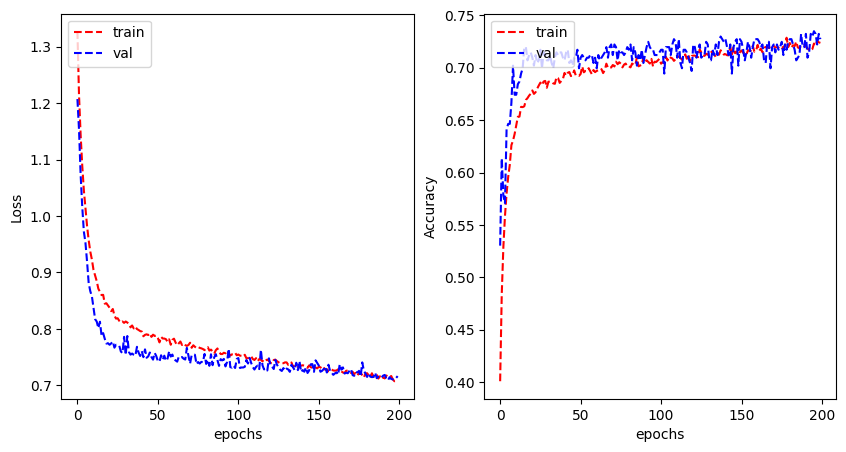

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg_drp.history['loss'], 'r--')
plt.plot(history_reg_drp.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(history_reg_drp.history['categorical_accuracy'], 'r--')
plt.plot(history_reg_drp.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
base_model.evaluate(test_generator)
base_model_reg.evaluate(test_generator)
add_lyrs_class.evaluate(test_generator)

50/50 [==============================] - 1s 12ms/step - loss: 0.7874 - categorical_accuracy: 0.6982 - precision_2: 0.7771 - recall_2: 0.6029 - auc_2: 0.8948


[0.7874295115470886,
 0.6982323527336121,
 0.777054488658905,
 0.6029040217399597,
 0.8948094248771667]

### Visualizing the prediction of the model(s) on Test data
+ The model with more layers
+ The regularized model
+ The base model


(-0.5, 26.5, 26.5, -0.5)

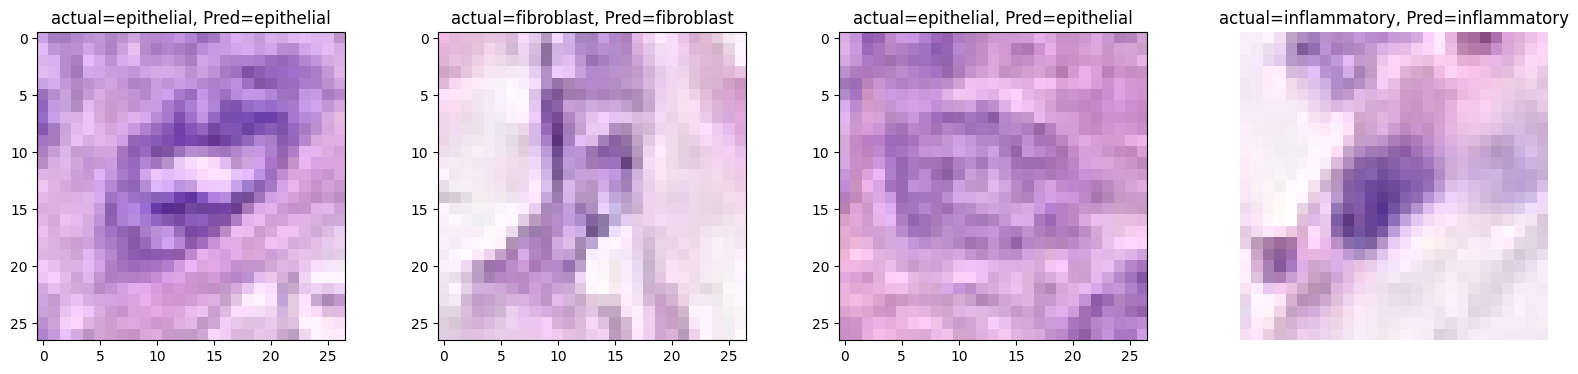

In [20]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'other' : 3 }
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(25,4))
batches = 0

for x,y in test_generator:
    batches = batches + 1
    y_hat = add_lyrs_class.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches < 5:
        plt.subplot(1,5, batches)
        plt.imshow(x[0])
        plt.title("actual={}, Pred={}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
    else:
        break
        
plt.axis('off')

(-0.5, 26.5, 26.5, -0.5)

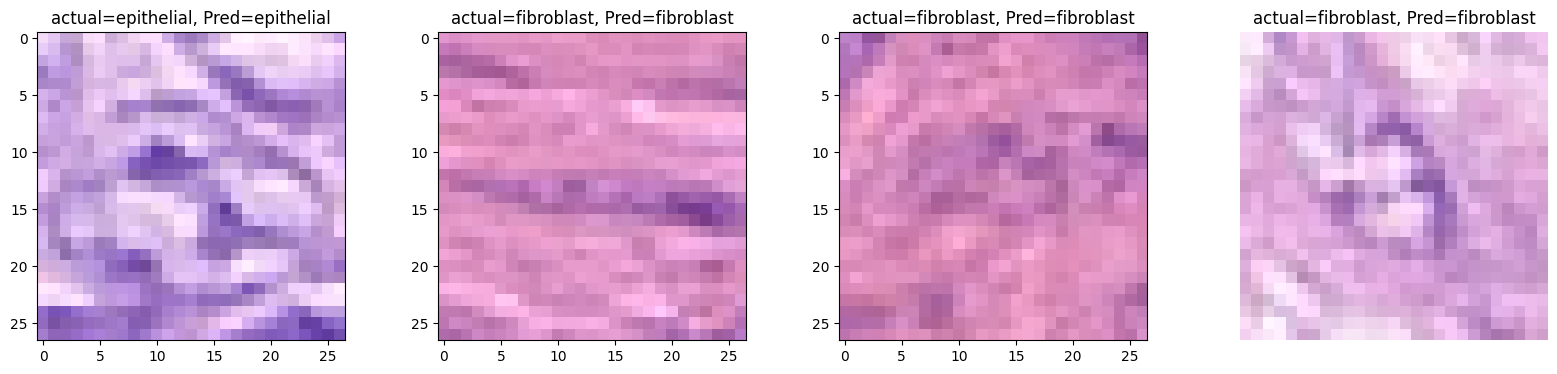

In [21]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'other' : 3 }
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(25,4))
batches = 0

for x,y in test_generator:
    batches = batches + 1
    y_hat = base_model_reg.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches < 5:
        plt.subplot(1,5, batches)
        plt.imshow(x[0])
        plt.title("actual={}, Pred={}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
    else:
        break
        
plt.axis('off')

### Adding more layers to the model (Advanced Model)

+ We add more `Conv2D` layers and `Dense` layers , we will increase `Dropout` and add more of this layer inorder to prevent the model from overfitting .
+ We use `Early Stopping` and `Model Checkpoint` in order to obtain the best model out of the 300 epoches running.

In [34]:
adv_model = Sequential([
    Conv2D(32, kernel_size = (3,3), activation = "relu", input_shape = (27,27,3)),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.35),
    Conv2D(64, kernel_size = (3,3), activation = "relu"),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.45),
    Conv2D(128, kernel_size = (3,3), activation = "relu"),
    Dropout(0.6),
    Conv2D(256, kernel_size = (3,3), activation = "relu"),
    Flatten(),
    Dense(512,activation = "relu"),
    Dense(256,activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dropout(0.6),
    Dense(4,activation = 'softmax')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=17, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath ='adv_classi.model', monitor='val_categorical_accuracy', mode='max', save_best_only=True, save_weights_only=False,verbose=1)

adv_model.compile(optimizer = Adam(learning_rate=1e-4),
                  loss = categorical_crossentropy, 
                  metrics=['categorical_accuracy', Precision(), Recall(), AUC()])

history_adv = adv_model.fit(train_generator, validation_data = validation_generator, epochs=300, verbose=1, callbacks=[early_stopping,model_checkpoint])

Epoch 1/300
247/248 [============================>.] - ETA: 0s - loss: 1.3315 - categorical_accuracy: 0.4033 - precision_5: 0.4050 - recall_5: 0.0062 - auc_5: 0.6316
Epoch 1: val_categorical_accuracy improved from -inf to 0.42424, saving model to adv_classi.model


INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 8s 30ms/step - loss: 1.3315 - categorical_accuracy: 0.4034 - precision_5: 0.4050 - recall_5: 0.0062 - auc_5: 0.6315 - val_loss: 1.3346 - val_categorical_accuracy: 0.4242 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_auc_5: 0.6694
Epoch 2/300
247/248 [============================>.] - ETA: 0s - loss: 1.2946 - categorical_accuracy: 0.4129 - precision_5: 0.5878 - recall_5: 0.0454 - auc_5: 0.6612
Epoch 2: val_categorical_accuracy did not improve from 0.42424
248/248 [==============================] - 5s 22ms/step - loss: 1.2947 - categorical_accuracy: 0.4123 - precision_5: 0.5862 - recall_5: 0.0460 - auc_5: 0.6610 - val_loss: 1.2197 - val_categorical_accuracy: 0.4242 - val_precision_5: 0.8929 - val_recall_5: 0.0631 - val_auc_5: 0.7334
Epoch 3/300
248/248 [==============================] - ETA: 0s - loss: 1.1369 - categorical_accuracy: 0.4976 - precision_5: 0.7621 - recall_5: 0.2659 - auc_5: 0.7617
Epoch 3: val_categorical_accuracy

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 28ms/step - loss: 1.1369 - categorical_accuracy: 0.4976 - precision_5: 0.7621 - recall_5: 0.2659 - auc_5: 0.7617 - val_loss: 1.0558 - val_categorical_accuracy: 0.5833 - val_precision_5: 0.8615 - val_recall_5: 0.2828 - val_auc_5: 0.8397
Epoch 4/300
247/248 [============================>.] - ETA: 0s - loss: 1.0162 - categorical_accuracy: 0.5866 - precision_5: 0.7726 - recall_5: 0.3690 - auc_5: 0.8226
Epoch 4: val_categorical_accuracy improved from 0.58333 to 0.66414, saving model to adv_classi.model


INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 30ms/step - loss: 1.0155 - categorical_accuracy: 0.5872 - precision_5: 0.7731 - recall_5: 0.3693 - auc_5: 0.8229 - val_loss: 0.9290 - val_categorical_accuracy: 0.6641 - val_precision_5: 0.8333 - val_recall_5: 0.3788 - val_auc_5: 0.8674
Epoch 5/300
247/248 [============================>.] - ETA: 0s - loss: 0.9338 - categorical_accuracy: 0.6353 - precision_5: 0.7638 - recall_5: 0.4557 - auc_5: 0.8517
Epoch 5: val_categorical_accuracy improved from 0.66414 to 0.67677, saving model to adv_classi.model


INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 29ms/step - loss: 0.9340 - categorical_accuracy: 0.6353 - precision_5: 0.7635 - recall_5: 0.4557 - auc_5: 0.8516 - val_loss: 0.8281 - val_categorical_accuracy: 0.6768 - val_precision_5: 0.8162 - val_recall_5: 0.4823 - val_auc_5: 0.8966
Epoch 6/300
247/248 [============================>.] - ETA: 0s - loss: 0.8787 - categorical_accuracy: 0.6630 - precision_5: 0.7594 - recall_5: 0.5143 - auc_5: 0.8689
Epoch 6: val_categorical_accuracy improved from 0.67677 to 0.68687, saving model to adv_classi.model


INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 29ms/step - loss: 0.8787 - categorical_accuracy: 0.6630 - precision_5: 0.7592 - recall_5: 0.5143 - auc_5: 0.8689 - val_loss: 0.8248 - val_categorical_accuracy: 0.6869 - val_precision_5: 0.8253 - val_recall_5: 0.4773 - val_auc_5: 0.8926
Epoch 7/300
247/248 [============================>.] - ETA: 0s - loss: 0.8545 - categorical_accuracy: 0.6726 - precision_5: 0.7637 - recall_5: 0.5284 - auc_5: 0.8757
Epoch 7: val_categorical_accuracy improved from 0.68687 to 0.69697, saving model to adv_classi.model


INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 30ms/step - loss: 0.8544 - categorical_accuracy: 0.6724 - precision_5: 0.7635 - recall_5: 0.5287 - auc_5: 0.8757 - val_loss: 0.7807 - val_categorical_accuracy: 0.6970 - val_precision_5: 0.8147 - val_recall_5: 0.5328 - val_auc_5: 0.9005
Epoch 8/300
247/248 [============================>.] - ETA: 0s - loss: 0.8367 - categorical_accuracy: 0.6777 - precision_5: 0.7684 - recall_5: 0.5445 - auc_5: 0.8813
Epoch 8: val_categorical_accuracy did not improve from 0.69697
248/248 [==============================] - 6s 22ms/step - loss: 0.8363 - categorical_accuracy: 0.6780 - precision_5: 0.7689 - recall_5: 0.5447 - auc_5: 0.8814 - val_loss: 0.7765 - val_categorical_accuracy: 0.6919 - val_precision_5: 0.8036 - val_recall_5: 0.5682 - val_auc_5: 0.9036
Epoch 9/300
248/248 [==============================] - ETA: 0s - loss: 0.8245 - categorical_accuracy: 0.6910 - precision_5: 0.7747 - recall_5: 0.5560 - auc_5: 0.8848
Epoch 9: val_categorical_accuracy improve

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 29ms/step - loss: 0.8245 - categorical_accuracy: 0.6910 - precision_5: 0.7747 - recall_5: 0.5560 - auc_5: 0.8848 - val_loss: 0.7226 - val_categorical_accuracy: 0.7045 - val_precision_5: 0.8156 - val_recall_5: 0.5808 - val_auc_5: 0.9138
Epoch 10/300
246/248 [============================>.] - ETA: 0s - loss: 0.8169 - categorical_accuracy: 0.6858 - precision_5: 0.7682 - recall_5: 0.5576 - auc_5: 0.8869
Epoch 10: val_categorical_accuracy improved from 0.70455 to 0.72222, saving model to adv_classi.model


INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 29ms/step - loss: 0.8165 - categorical_accuracy: 0.6858 - precision_5: 0.7679 - recall_5: 0.5576 - auc_5: 0.8869 - val_loss: 0.6997 - val_categorical_accuracy: 0.7222 - val_precision_5: 0.8069 - val_recall_5: 0.5909 - val_auc_5: 0.9194
Epoch 11/300
248/248 [==============================] - ETA: 0s - loss: 0.7954 - categorical_accuracy: 0.6948 - precision_5: 0.7797 - recall_5: 0.5733 - auc_5: 0.8924
Epoch 11: val_categorical_accuracy improved from 0.72222 to 0.73232, saving model to adv_classi.model


INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 29ms/step - loss: 0.7954 - categorical_accuracy: 0.6948 - precision_5: 0.7797 - recall_5: 0.5733 - auc_5: 0.8924 - val_loss: 0.7037 - val_categorical_accuracy: 0.7323 - val_precision_5: 0.8121 - val_recall_5: 0.6111 - val_auc_5: 0.9187
Epoch 12/300
246/248 [============================>.] - ETA: 0s - loss: 0.7899 - categorical_accuracy: 0.6984 - precision_5: 0.7767 - recall_5: 0.5759 - auc_5: 0.8940
Epoch 12: val_categorical_accuracy did not improve from 0.73232
248/248 [==============================] - 6s 22ms/step - loss: 0.7893 - categorical_accuracy: 0.6991 - precision_5: 0.7770 - recall_5: 0.5763 - auc_5: 0.8942 - val_loss: 0.6888 - val_categorical_accuracy: 0.7222 - val_precision_5: 0.8073 - val_recall_5: 0.6136 - val_auc_5: 0.9220
Epoch 13/300
248/248 [==============================] - ETA: 0s - loss: 0.7782 - categorical_accuracy: 0.7031 - precision_5: 0.7835 - recall_5: 0.5844 - auc_5: 0.8968
Epoch 13: val_categorical_accuracy did

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 8s 30ms/step - loss: 0.7777 - categorical_accuracy: 0.7041 - precision_5: 0.7828 - recall_5: 0.5899 - auc_5: 0.8970 - val_loss: 0.6855 - val_categorical_accuracy: 0.7449 - val_precision_5: 0.8261 - val_recall_5: 0.6237 - val_auc_5: 0.9259
Epoch 15/300
247/248 [============================>.] - ETA: 0s - loss: 0.7717 - categorical_accuracy: 0.7083 - precision_5: 0.7821 - recall_5: 0.5958 - auc_5: 0.8995
Epoch 15: val_categorical_accuracy did not improve from 0.74495
248/248 [==============================] - 6s 24ms/step - loss: 0.7727 - categorical_accuracy: 0.7078 - precision_5: 0.7815 - recall_5: 0.5954 - auc_5: 0.8992 - val_loss: 0.6799 - val_categorical_accuracy: 0.7273 - val_precision_5: 0.7954 - val_recall_5: 0.6086 - val_auc_5: 0.9237
Epoch 16/300
248/248 [==============================] - ETA: 0s - loss: 0.7599 - categorical_accuracy: 0.7127 - precision_5: 0.7889 - recall_5: 0.6006 - auc_5: 0.9021
Epoch 16: val_categorical_accuracy imp

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 29ms/step - loss: 0.7599 - categorical_accuracy: 0.7127 - precision_5: 0.7889 - recall_5: 0.6006 - auc_5: 0.9021 - val_loss: 0.6562 - val_categorical_accuracy: 0.7475 - val_precision_5: 0.8125 - val_recall_5: 0.6566 - val_auc_5: 0.9282
Epoch 17/300
246/248 [============================>.] - ETA: 0s - loss: 0.7534 - categorical_accuracy: 0.7117 - precision_5: 0.7881 - recall_5: 0.6093 - auc_5: 0.9035
Epoch 17: val_categorical_accuracy did not improve from 0.74747
248/248 [==============================] - 6s 23ms/step - loss: 0.7518 - categorical_accuracy: 0.7127 - precision_5: 0.7891 - recall_5: 0.6102 - auc_5: 0.9039 - val_loss: 0.7007 - val_categorical_accuracy: 0.7197 - val_precision_5: 0.7929 - val_recall_5: 0.6187 - val_auc_5: 0.9155
Epoch 18/300
246/248 [============================>.] - ETA: 0s - loss: 0.7463 - categorical_accuracy: 0.7145 - precision_5: 0.7876 - recall_5: 0.6156 - auc_5: 0.9054
Epoch 18: val_categorical_accuracy did

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 8s 31ms/step - loss: 0.6414 - categorical_accuracy: 0.7617 - precision_5: 0.8281 - recall_5: 0.6745 - auc_5: 0.9308 - val_loss: 0.5902 - val_categorical_accuracy: 0.7551 - val_precision_5: 0.8349 - val_recall_5: 0.6894 - val_auc_5: 0.9404
Epoch 51/300
247/248 [============================>.] - ETA: 0s - loss: 0.6428 - categorical_accuracy: 0.7589 - precision_5: 0.8288 - recall_5: 0.6781 - auc_5: 0.9305
Epoch 51: val_categorical_accuracy did not improve from 0.75505
248/248 [==============================] - 6s 25ms/step - loss: 0.6427 - categorical_accuracy: 0.7585 - precision_5: 0.8284 - recall_5: 0.6777 - auc_5: 0.9305 - val_loss: 0.5768 - val_categorical_accuracy: 0.7449 - val_precision_5: 0.8400 - val_recall_5: 0.6894 - val_auc_5: 0.9428
Epoch 52/300
248/248 [==============================] - ETA: 0s - loss: 0.6455 - categorical_accuracy: 0.7556 - precision_5: 0.8233 - recall_5: 0.6753 - auc_5: 0.9298
Epoch 52: val_categorical_accuracy did

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 29ms/step - loss: 0.6228 - categorical_accuracy: 0.7695 - precision_5: 0.8290 - recall_5: 0.6945 - auc_5: 0.9344 - val_loss: 0.5722 - val_categorical_accuracy: 0.7626 - val_precision_5: 0.8374 - val_recall_5: 0.6894 - val_auc_5: 0.9438
Epoch 56/300
247/248 [============================>.] - ETA: 0s - loss: 0.6365 - categorical_accuracy: 0.7640 - precision_5: 0.8287 - recall_5: 0.6774 - auc_5: 0.9319
Epoch 56: val_categorical_accuracy did not improve from 0.76263
248/248 [==============================] - 5s 21ms/step - loss: 0.6358 - categorical_accuracy: 0.7641 - precision_5: 0.8287 - recall_5: 0.6777 - auc_5: 0.9320 - val_loss: 0.5990 - val_categorical_accuracy: 0.7525 - val_precision_5: 0.8119 - val_recall_5: 0.6869 - val_auc_5: 0.9382
Epoch 57/300
246/248 [============================>.] - ETA: 0s - loss: 0.6336 - categorical_accuracy: 0.7610 - precision_5: 0.8235 - recall_5: 0.6816 - auc_5: 0.9320
Epoch 57: val_categorical_accuracy did

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 27ms/step - loss: 0.6103 - categorical_accuracy: 0.7720 - precision_5: 0.8303 - recall_5: 0.6953 - auc_5: 0.9374 - val_loss: 0.5964 - val_categorical_accuracy: 0.7753 - val_precision_5: 0.8378 - val_recall_5: 0.7045 - val_auc_5: 0.9380
Epoch 64/300
247/248 [============================>.] - ETA: 0s - loss: 0.6193 - categorical_accuracy: 0.7716 - precision_5: 0.8323 - recall_5: 0.6946 - auc_5: 0.9355
Epoch 64: val_categorical_accuracy did not improve from 0.77525
248/248 [==============================] - 5s 21ms/step - loss: 0.6205 - categorical_accuracy: 0.7712 - precision_5: 0.8316 - recall_5: 0.6945 - auc_5: 0.9352 - val_loss: 0.6274 - val_categorical_accuracy: 0.7323 - val_precision_5: 0.7942 - val_recall_5: 0.6919 - val_auc_5: 0.9333
Epoch 65/300
246/248 [============================>.] - ETA: 0s - loss: 0.6147 - categorical_accuracy: 0.7725 - precision_5: 0.8316 - recall_5: 0.6964 - auc_5: 0.9362
Epoch 65: val_categorical_accuracy did

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 28ms/step - loss: 0.5958 - categorical_accuracy: 0.7778 - precision_5: 0.8306 - recall_5: 0.7050 - auc_5: 0.9405 - val_loss: 0.5502 - val_categorical_accuracy: 0.7803 - val_precision_5: 0.8487 - val_recall_5: 0.7222 - val_auc_5: 0.9476
Epoch 76/300
247/248 [============================>.] - ETA: 0s - loss: 0.5806 - categorical_accuracy: 0.7813 - precision_5: 0.8424 - recall_5: 0.7139 - auc_5: 0.9431
Epoch 76: val_categorical_accuracy did not improve from 0.78030
248/248 [==============================] - 5s 21ms/step - loss: 0.5808 - categorical_accuracy: 0.7811 - precision_5: 0.8424 - recall_5: 0.7137 - auc_5: 0.9431 - val_loss: 0.5827 - val_categorical_accuracy: 0.7449 - val_precision_5: 0.8211 - val_recall_5: 0.7071 - val_auc_5: 0.9415
Epoch 77/300
247/248 [============================>.] - ETA: 0s - loss: 0.5924 - categorical_accuracy: 0.7854 - precision_5: 0.8377 - recall_5: 0.7062 - auc_5: 0.9407
Epoch 77: val_categorical_accuracy did

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 27ms/step - loss: 0.5811 - categorical_accuracy: 0.7834 - precision_5: 0.8386 - recall_5: 0.7180 - auc_5: 0.9429 - val_loss: 0.5366 - val_categorical_accuracy: 0.7904 - val_precision_5: 0.8371 - val_recall_5: 0.7399 - val_auc_5: 0.9498
Epoch 82/300
247/248 [============================>.] - ETA: 0s - loss: 0.5892 - categorical_accuracy: 0.7797 - precision_5: 0.8362 - recall_5: 0.7135 - auc_5: 0.9417
Epoch 82: val_categorical_accuracy did not improve from 0.79040
248/248 [==============================] - 6s 22ms/step - loss: 0.5893 - categorical_accuracy: 0.7794 - precision_5: 0.8362 - recall_5: 0.7132 - auc_5: 0.9417 - val_loss: 0.5475 - val_categorical_accuracy: 0.7753 - val_precision_5: 0.8333 - val_recall_5: 0.7071 - val_auc_5: 0.9476
Epoch 83/300
246/248 [============================>.] - ETA: 0s - loss: 0.5785 - categorical_accuracy: 0.7852 - precision_5: 0.8376 - recall_5: 0.7148 - auc_5: 0.9434
Epoch 83: val_categorical_accuracy did

INFO:tensorflow:Assets written to: adv_classi.model\assets


INFO:tensorflow:Assets written to: adv_classi.model\assets


248/248 [==============================] - 7s 29ms/step - loss: 0.5372 - categorical_accuracy: 0.8060 - precision_5: 0.8540 - recall_5: 0.7448 - auc_5: 0.9513 - val_loss: 0.5042 - val_categorical_accuracy: 0.7980 - val_precision_5: 0.8519 - val_recall_5: 0.7551 - val_auc_5: 0.9560
Epoch 105/300
246/248 [============================>.] - ETA: 0s - loss: 0.5433 - categorical_accuracy: 0.7999 - precision_5: 0.8487 - recall_5: 0.7384 - auc_5: 0.9498
Epoch 105: val_categorical_accuracy did not improve from 0.79798
248/248 [==============================] - 5s 22ms/step - loss: 0.5427 - categorical_accuracy: 0.8004 - precision_5: 0.8488 - recall_5: 0.7385 - auc_5: 0.9499 - val_loss: 0.5072 - val_categorical_accuracy: 0.7929 - val_precision_5: 0.8530 - val_recall_5: 0.7475 - val_auc_5: 0.9556
Epoch 106/300
247/248 [============================>.] - ETA: 0s - loss: 0.5358 - categorical_accuracy: 0.8040 - precision_5: 0.8520 - recall_5: 0.7425 - auc_5: 0.9511
Epoch 106: val_categorical_accuracy

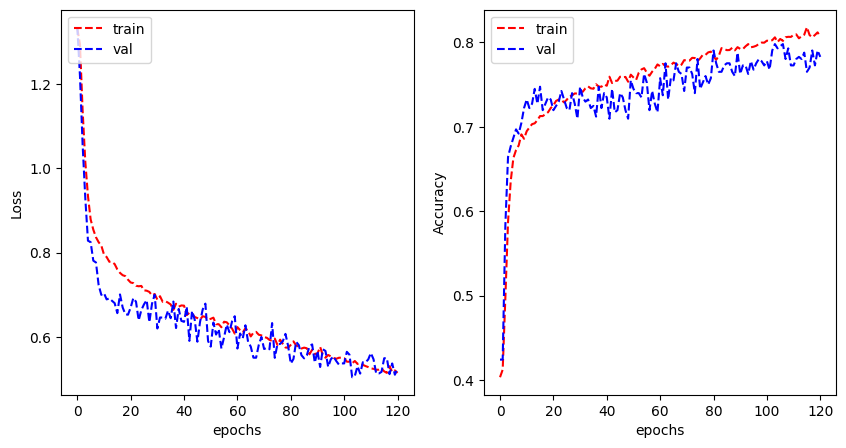

In [35]:
adv_class_model = load_model('adv_classi.model')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_adv.history['loss'], 'r--')
plt.plot(history_adv.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')


plt.subplot(1,2,2)
plt.plot(history_adv.history['categorical_accuracy'], 'r--')
plt.plot(history_adv.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.show()

In [36]:
adv_class_model.evaluate(test_generator)

50/50 [==============================] - 1s 15ms/step - loss: 0.6100 - categorical_accuracy: 0.7727 - precision_5: 0.8138 - recall_5: 0.7229 - auc_5: 0.9376


[0.6100022196769714,
 0.7727272510528564,
 0.8137881755828857,
 0.7228535413742065,
 0.9375942349433899]

(-0.5, 26.5, 26.5, -0.5)

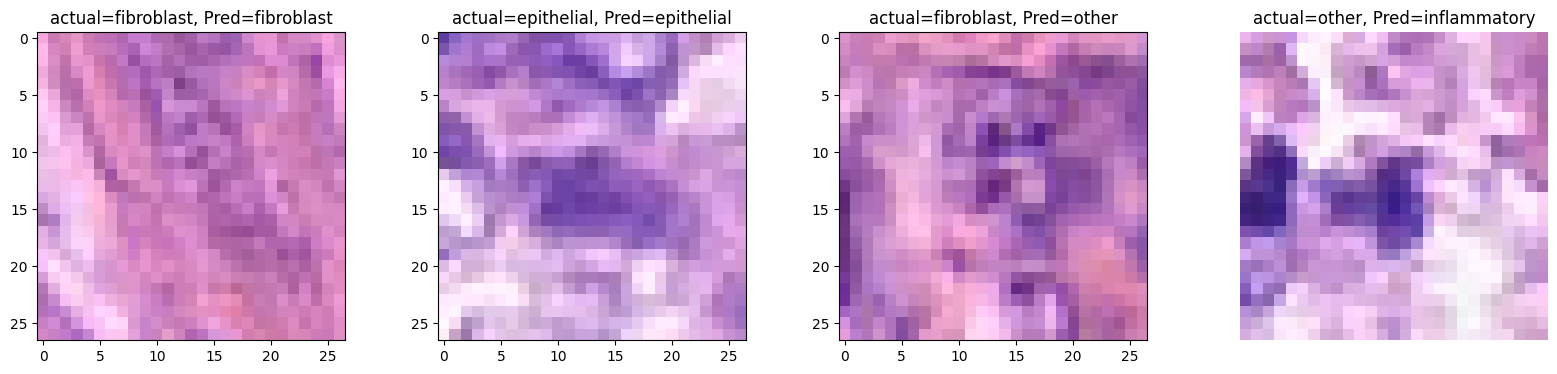

In [37]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'other' : 3 }
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(25,4))
batches = 0

for x,y in test_generator:
    batches = batches + 1
    y_hat = adv_class_model.predict(x, verbose=0)
    x = np.squeeze(x)
    if batches < 5:
        plt.subplot(1,5, batches)
        plt.imshow(x[0])
        plt.title("actual={}, Pred={}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
    else:
        break
        
plt.axis('off')

##  Table of the evaluation metrics used 

In [38]:
test_loss_adv, test_accuracy_adv, test_precision_adv, test_recall_adv, test_auc_adv = adv_model.evaluate(test_generator)
test_loss_addL, test_accuracy_addL, test_precision_addL, test_recall_addL, test_auc_addL = add_lyrs_class.evaluate(test_generator)
test_loss_reg, test_accuracy_reg, test_precision_reg, test_recall_reg, test_auc_reg = base_model_reg.evaluate(test_generator)

y_pred_adv = adv_model.predict(test_generator)

y_true = test_generator.classes

from tabulate import tabulate

metrics = ["test_loss", "test_accuracy", "test_precision", "test_recall", "test_auc"]
models = ["adv", "addL", "reg"]

data = [
    [test_loss_adv, test_accuracy_adv, test_precision_adv, test_recall_adv, test_auc_adv],
    [test_loss_addL, test_accuracy_addL, test_precision_addL, test_recall_addL, test_auc_addL],
    [test_loss_reg, test_accuracy_reg, test_precision_reg, test_recall_reg, test_auc_reg]
]

table = tabulate(data, headers=metrics, showindex=models, tablefmt="grid")

print(table)

50/50 [==============================] - 1s 14ms/step
+------+-------------+-----------------+------------------+---------------+------------+
|      |   test_loss |   test_accuracy |   test_precision |   test_recall |   test_auc |
+======+=============+=================+==================+===============+============+
| adv  |    0.610002 |        0.772727 |         0.813788 |      0.722854 |   0.937594 |
+------+-------------+-----------------+------------------+---------------+------------+
| addL |    0.787429 |        0.698232 |         0.777054 |      0.602904 |   0.894809 |
+------+-------------+-----------------+------------------+---------------+------------+
| reg  |    0.905644 |        0.691288 |         0.784425 |      0.521465 |   0.88572  |
+------+-------------+-----------------+------------------+---------------+------------+


# References

+ https://towardsdatascience.com/early-stopping-a-cool-strategy-to-regularize-neural-networks-bfdeca6d722e
+ https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
+ https://pypi.org/project/tabulate/
+ https://www.askpython.com/python-modules/tabulate-tables-in-python
+ Week 9 labs and Q & A 